# Reto Técnico Cientifico de Datos

## 1. Analisis review de Pichfork.com

<p><img style="float: right;margin:5px 20px 10px 1px; max-width:250px" src="https://www.vrfocus.com/wp-content/uploads/2017/07/pitchfork-logo2.png"></p>
<p>Pitchfork Media, o simplemente Pitchfork. Está dedicada a la crítica y comentarios de música, noticias musicales y entrevistas a artistas. Está enfocada principalmente a la música independiente,​ incluyendo el indie rock. Aunque, en menor medida, abarcan géneros musicales que como electrónica, el pop, el hip hop, la música dance, el folk, el jazz y la música experimental.</p>
<p>El sitio, que se fundó en 1995, se concentra en las novedades musicales, pero los periodistas de Pitchfork también repasan álbumes y cajas recopilatorias ya editadas.</p>

##### Fuente: <a href="https://www.pitchfork.com">https://www.pitchfork.com</a> & <a href="https://es.wikipedia.org/wiki/Pitchfork_Media">https://wikipedia.com</a>

In [19]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from timeit import default_timer as timer
import time
import warnings
warnings.filterwarnings('ignore')

cmap=sns.color_palette('Blues_r')

%matplotlib inline

!pip install plotly

## 1.1. Contexto

<p>El siguiente conjunto de datos consiste en mas de 18.000 reviews que la empresa pichfork elaboro desde el 05 de enero de 1999 hasta el 08 de enero de 2017. Aquellos que visitan el sitio de Pitchfork y leen sus reseñas tienen más o menos probabilidades de escuchar a un artista, álbum o canción en particular en función de lo que leen. Por lo tanto, las reseñas del sitio, tanto positivas como negativas, se han considerado ampliamente influyentes para hacer o romper la carrera de los músicos. Como resultado, algunos ven el sitio como un barómetro de la música independiente.</p>
<p>Ante tal situación  analizaremos si Pitchfork tiene un impacto negativo en las carreras de algunos artistas, y si los autores de las reviews del sitio han tenido preferencias o prejuicios en contra de ciertos géneros. Tambien pondremos en tela de juicio si Pitchfork favorece el lo-fi, el indie rock y otros géneros musicales más oscuros, y que las reviews escriben críticas con opiniones provocativas y poco convencionales para llamar la atención.</p>

## 1.2. Importación de datos

<p>Se usara una base de datos de tipo SQLite3, la cual contiene información de reviews, artistas, géneros e información relacionada al tema de análisis. Para una mejor interpretación se unificara en una única tabla llamada "df", aplicando el proceso de limpieza de datos y eliminación de duplicados.
</p>
<p>Para tener un análisis uniforme no se utilizaran los registros con valores nullos o duplicados, ya que estos no se consideran relevantes para el análisis. Igualmente se los dejara alojado en df_null y df_duplicado de ser necesario un análisis previo especifico sobre los mismos.</p>


In [20]:
#Carga de la base de datos.
conn = sqlite3.connect('ds-challenge.sqlite')
#Armado de cada tabla en un dataframe:

df_artists = pd.read_sql_query("SELECT * FROM artists", conn)
df_content = pd.read_sql_query("SELECT * FROM content", conn)
df_genres = pd.read_sql_query("SELECT * FROM genres", conn)
df_labels = pd.read_sql_query("SELECT * FROM labels", conn)
df_reviews = pd.read_sql_query("SELECT * FROM reviews", conn)
df_years = pd.read_sql_query("SELECT * FROM years", conn)

#Seteo de index 
df_reviews.set_index('reviewid', inplace=True)
df_genres.set_index('reviewid', inplace=True)
df_content.set_index('reviewid', inplace=True)
df_years.set_index('reviewid', inplace=True)
df_labels.set_index('reviewid', inplace=True)

df = pd.merge(df_reviews, df_genres, left_index=True, right_index=True)
df = pd.merge(df, df_content, left_index=True, right_index=True)
df = pd.merge(df, df_years, left_index=True, right_index=True)
df = pd.merge(df, df_labels, left_index=True, right_index=True)

#limpieza de datos y normalizacion de los datos 

df.drop(['url'], axis=1, inplace=True)

#separar registros nulls en un nuevo dataframe
df_null = df[df.isnull().any(axis=1)]
df.dropna(inplace=True)

#separar los datos repetidos en un nuevo dataframe
df_duplicates = df[df.duplicated(keep=False)]
df.drop_duplicates(keep=False, inplace=True)

print(f"Cantidades de nulls: {df_null.shape[0]}")
print(f"Cantidades de duplicados: {df_duplicates.shape[0]}")
print(f"Cantidades de registros a trabajar: {df.shape[0]}")
print(f"Cantidades de variables: {df.shape[1]}")
print('======= Datos ========')
df.info()




Cantidades de nulls: 8114
Cantidades de duplicados: 96
Cantidades de registros a trabajar: 17808
Cantidades de variables: 15
======= Datos ========
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17808 entries, 1 to 22745
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           17808 non-null  object 
 1   artist          17808 non-null  object 
 2   score           17808 non-null  float64
 3   best_new_music  17808 non-null  int64  
 4   author          17808 non-null  object 
 5   author_type     17808 non-null  object 
 6   pub_date        17808 non-null  object 
 7   pub_weekday     17808 non-null  int64  
 8   pub_day         17808 non-null  int64  
 9   pub_month       17808 non-null  int64  
 10  pub_year        17808 non-null  int64  
 11  genre           17808 non-null  object 
 12  content         17808 non-null  object 
 13  year            17808 non-null  float64
 14  label           17

## 1.3. Descripción de los datos a trabajar.

<p>Antes de realizar los primeros análisis explotarios, analizaremos las cantidades de variables dentro de cada columna del Dataframe “df”, esto le simplificara a el lector la información que se esta manipulando en cada tipo de análisis, Se sugiere que se mantenga como una tabla referencial. </p>


In [21]:
#Descripcion de los datos
variables = pd.DataFrame(columns=['Variable','Numero de Variables Unicas','Valores'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
    
variables.sort_values(by=['Numero de Variables Unicas'], ascending=False, inplace=True)
variables.reset_index(drop=True, inplace=True)
display(variables)

,Variable,Numero de Variables Unicas,Valores
0,content,12343,"[Aberfeldy recorded their debut, Young Forever..."
1,title,12031,"[young forever, pure tone audiometry, homesick..."
2,artist,6173,"[aberfeldy, aarktica, aberdeen, aceyalone, aci..."
3,pub_date,3715,"[2004-08-30, 2003-04-08, 2002-11-04, 2003-06-1..."
4,label,2781,"[rough trade, silber, better looking, deconstr..."
5,author,246,"[marc hogan, eric carr, joe tangari, andy beta..."
6,score,97,"[3.4, 7.4, 7.0, 6.7, 7.5, 3.2, 8.4, 8.3, 6.8, ..."
7,year,57,"[2004.0, 2003.0, 2002.0, 2006.0, 2005.0, 2001...."
8,pub_day,31,"[30, 8, 4, 15, 2, 12, 13, 20, 14, 9, 31, 21, 6..."
9,pub_year,19,"[2004, 2003, 2002, 2006, 2005, 2000, 2001, 199..."


## 1.4 Análisis exploratorio 1

<p>Abarcaremos el primer análisis genérico referenciado a la pregunta si Pitchfork favorece a algún genero musical o desfavorece a otros?
<p>Por lo cual se desarrolla inicialmente las siguientes preguntas: </p>
<li>1.4.1 ¿Cuál es la cantidad de reviews por Genero?</li>
<li>1.4.2 ¿Cuál es la distribución general de las puntuaciones otorgadas por Pitchfork?</li>
<li>1.4.3 ¿Cuál es la menor y mayor distribución general de las puntuaciones otorgadas por Pitchfork?</li>
<li>1.4.4 ¿Cuál es la distribución de review por genero elaborado por Pitchfork?</li>
<li>1.4.5 ¿Cuales son los mejores y peores Artista analizados por Pitchfork?</li>



### 1.4.1 ¿Cuál es la cantidad de reviews por Genero?
<p>De la muestra de 17.808 registro se obtienen los siguientes resultados:</p>
<li>La mayor concentración de reviews que genera Pitchfork se encuentra en el genero "Rock", "Electronic" y "Experimental" con una cantidad de reviews de 13.203 con el 74.14% del total de la muestra.</li>
<li>Pitchfork es fiel a sus raíces y analiza principalmente los álbumes de rock sobre otros géneros. Global y Jazz tienen el menor número de reseñas, por lo que cada reseña individual en esa categoría tendrá una mayor influencia en su puntaje promedio. Aunque nuestro conjunto de datos solo tiene un género por revisión de álbum, es importante tener en cuenta que algunos álbumes se enumeran en varios géneros.</li>


In [22]:
#Armado de tabla de variables, frecuencia y porcentaje de cada variable de df['genre']:
# Count the number of review in each 'genre'. 
num_review_in_genre = df['genre'].value_counts()
df_frec_genre = pd.DataFrame(num_review_in_genre)
#Asignar el nombre de frecuencia a la columna
df_frec_genre.columns = ['frecuencia Absoluta']
#Determinar la frecuencia relativa en porcentaje
df_frec_genre['frecuencia Relativa'] = df_frec_genre['frecuencia Absoluta'] / df_frec_genre['frecuencia Absoluta'].sum()
#Determinar el porcentaje de cada variable
df_frec_genre['frecuencia Relativa'] = df_frec_genre['frecuencia Relativa'] *100
#Ordenar la tabla por frecuencia relativa
df_frec_genre.sort_values(by=['frecuencia Relativa'], ascending=False, inplace=True)
#Determinar el porcentaje acumulado de la frecuencia relativa
df_frec_genre['frecuencia Relativa Acumulada'] = df_frec_genre['frecuencia Relativa'].cumsum()
#Asignar el nombre de porcentaje a la columna
df_frec_genre.columns = ['frecuencia Absoluta', 'frecuencia Relativa','frecuencia Relativa Acumulada']
#Mostrar la tabla
pd.options.display.float_format = '{:.2f}%'.format
display(df_frec_genre)
pd.options.display.float_format = '{:.2f}'.format

,frecuencia Absoluta,frecuencia Relativa,frecuencia Relativa Acumulada
rock,8194,46.01%,46.01%
electronic,3395,19.06%,65.08%
experimental,1614,9.06%,74.14%
rap,1501,8.43%,82.57%
pop/r&b,1314,7.38%,89.95%
metal,628,3.53%,93.47%
folk/country,611,3.43%,96.91%
jazz,349,1.96%,98.87%
global,202,1.13%,100.00%


In [23]:
# Desarrollo de la distribucion de cantidades de reviews por generos
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go


print('Distribucíon de cantidades de review por genero')
# Print the total number of unique genre
num_genre = len(df['genre'].unique())
print('Numero de generos = ', num_genre)

# Sort num_review_in_genre in descending order based on the count of df in each genre
sorted_num_review_in_genre = num_review_in_genre.sort_values(ascending = False)

data = [go.Bar(
        x = num_review_in_genre.index, # index = category name
        y = sorted_num_review_in_genre.values, # value = count
        marker = dict(
            color = '#007894',
            
            line = dict(
                color = 'rgb(8,48,107)',
                width = 1.5,
            ),
        ),
        
        
)]

plotly.offline.iplot(data)



Distribucíon de cantidades de review por genero
Numero de generos =  9


### 1.4.2 ¿Cuál es la distribución general de las puntuaciones otorgadas por Pitchfork?
<p>Analizando la distribución de las puntuaciones otorgadas por Pitchfork, observamos que el promedio de las puntuaciones es 7 , con una desviación estándar de 1.29, la cual llevaría a pensar que en promedio las reviews tienen puntuaciones altas. </p>
<p>Si bien entre los géneros no existe una brecha demasiada grande entre las puntuaciones promedio, podemos afirmar que posiblemente exista una fuerte falta de sesgo a favor o en contra de cualquier género.</p>
<p>Igualmente dentro de los mejores y peores puntuados, observamos que se encuentra liderando el genero Global y Jazz (Géneros que si bien la cantidad de reviews son pocas en relación al resto, estos géneros son mas sensibles la variación del promedio por scores altos y bajos) aunque estos no sea representativos de la muestra. En contra partida, los géneros Electronic, Rap y Pop/r&b que al tener mayor cantidad de reviews que los géneros mejor puntuados su scoring global esta por debajo de la media total junto con el genero Rock.</p>
<p>Continuando con la ultima aclaración, el scoring no es representativo para determinar si un genero es mejor o peor que otro genero dentro del rango de años 1999 y 2017. </p>




In [24]:
df_genre_score = df[['genre','score']]
df_genre_score.describe()

,score
count,17808.00
mean,7.07
std,1.29
min,0.00
25%,6.50
50%,7.30
75%,7.90
max,10.00


In [25]:
#Promedio de scoring por genero
avg_score_in_genre = df_genre_score.groupby('genre').mean()
avg_score_in_genre = avg_score_in_genre.sort_values(by='score',ascending = False)
avg_score_in_genre=avg_score_in_genre.reset_index()
display(avg_score_in_genre)

,genre,score
0,global,7.47
1,jazz,7.44
2,experimental,7.39
3,folk/country,7.31
4,metal,7.12
5,rock,7.05
6,pop/r&b,7.01
7,electronic,6.97
8,rap,6.90


=== Distribución de cantidades de score por generos musicales ===


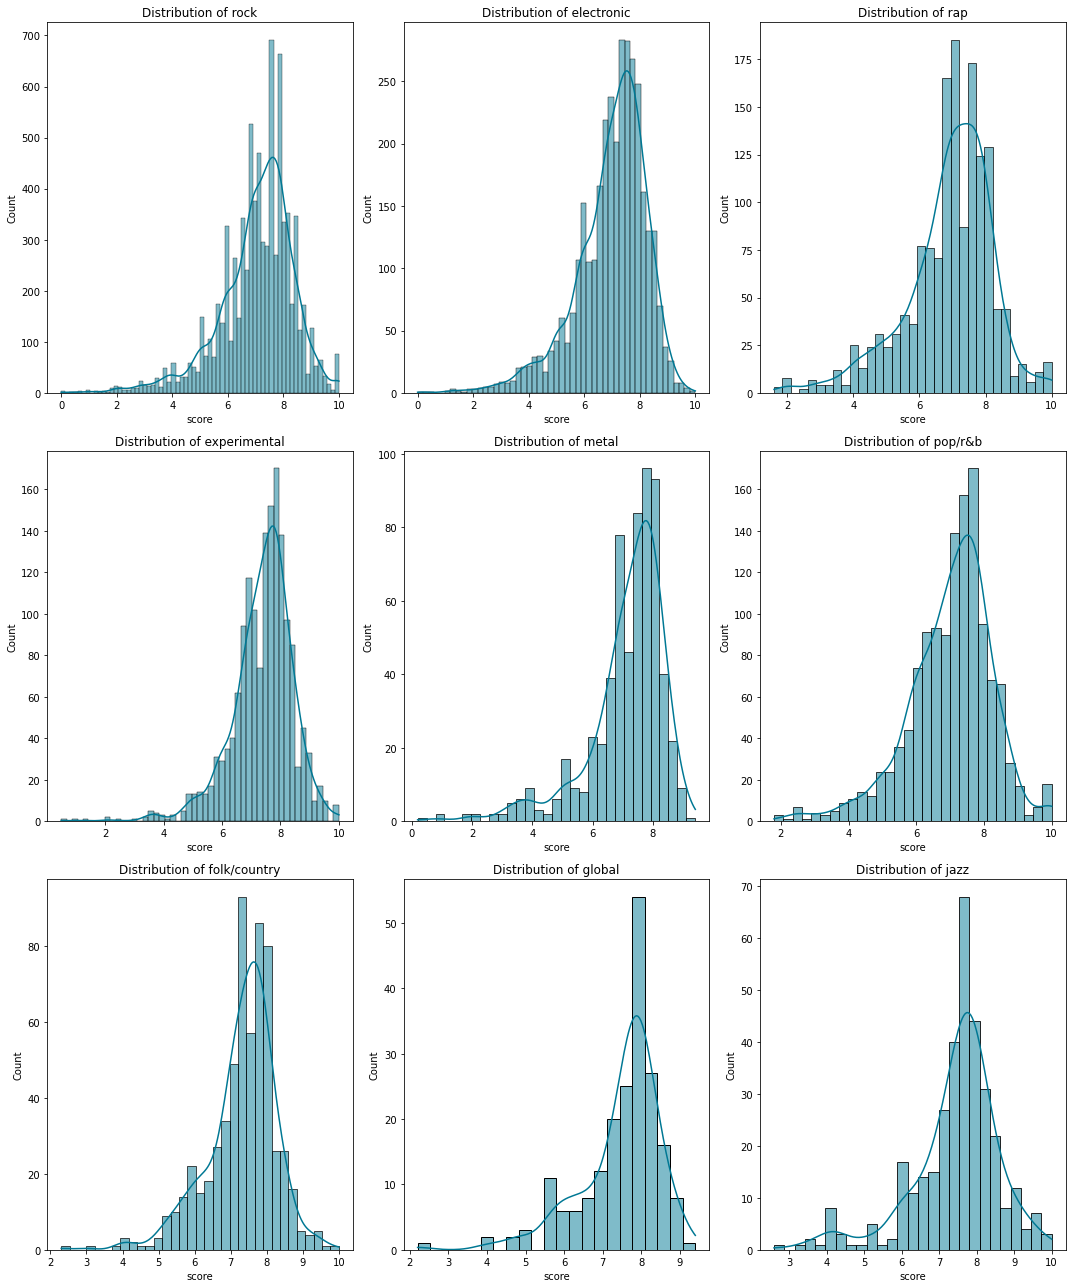

In [26]:
#Cantidad de scores por genero 
df_genre_score = df[['genre','score']].reset_index(drop=True)

# Check distribution (genre)
print(f'=== Distribución de cantidades de score por generos musicales ===')
plt.figure(figsize=(15, 18))
for i, genre in enumerate(df_genre_score['genre'].unique().tolist()):
    # Plot distribution 
    plt.subplot(3,3,i+1); sns.histplot(df_genre_score[df_genre_score['genre'] == genre]['score'], color='#007894', kde=True)
    plt.title(f'Distribution of {genre}')
# Show the plot
plt.tight_layout()
plt.show()

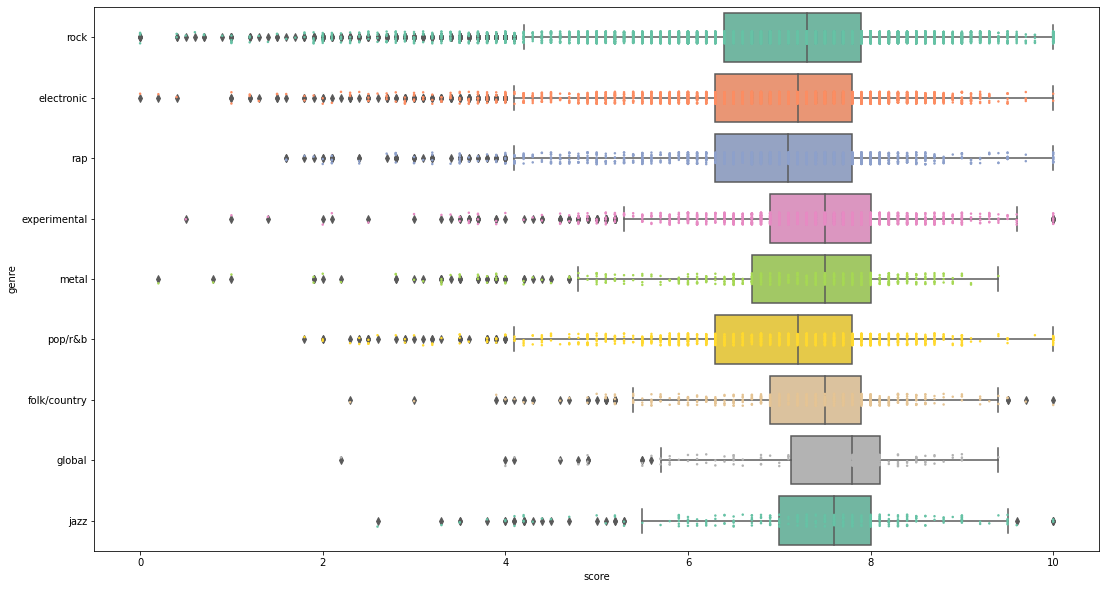

In [27]:
#Distribucion de scores promedio por genero
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.stripplot(data = df_genre_score, y = 'genre', x = 'score', jitter=True, size=2.5, palette="Set2")
ax = sns.boxplot(data = df_genre_score, y = 'genre', x = 'score',palette="Set2", orient="h")

## 1.4.5 Análisis de los mejores y peores artistas por genero.
<p> Para analizar los artistas de cada genero es necesario poder identificarlos con un criterio en común, en este caso solamente se van a tomar aquellos artistas que tengas mas de 2 títulos diferentes y como segundo criterio de selección se tendrá en cuenta en base el scoring promedio que haya obtenido en la muestra.</p>
<p>Para esto se utilizara una función de ordenamiento de datos, la cual ordenara los artistas por su promedio de scoring, de mayor a menor, y luego se tomaran los primeros 5 artistas y los peores 5 artistas de cada genero.</p>
<p>Este conjunto de datos servirá para luego analizar el conjunto de reviews generado por los escritores de Pitchfork.</p>



In [28]:
#Armado de tabla agrupando por df['genre'], df['artist'], df['score'] y cantidad de df['title']
df_genre_artist_score = df[['genre','artist','score','title']].reset_index(drop=True)
df_genre_artist_score.head()

#Agrupar por genre, artist ,avg score y cantidad de df['title']
df_genre_artist_score_grouped = df_genre_artist_score.groupby(['genre','artist']).mean()
df_genre_artist_score_grouped = df_genre_artist_score_grouped.reset_index()
#agregar cantidades de title
df_genre_artist_score_grouped1 = df_genre_artist_score.groupby(['genre','artist']).size()
df_genre_artist_score_grouped1 = df_genre_artist_score_grouped1.reset_index()
df_genre_artist_score_grouped1.columns = ['genre','artist','cantidad']
df_genre_artist_score_grouped['cantidad'] = df_genre_artist_score_grouped1['cantidad']


#filtrar df_genre_artist_score_grouped para que solo se muestren los artistas con mas de 2 titulos
df_genre_artist_score_grouped_filtered = df_genre_artist_score_grouped[df_genre_artist_score_grouped['cantidad']>2]


#definir el ranking de artistas por genero en base al score y cantidad de df['title']
df_genre_artist_score_grouped_filtered['ranking'] = df_genre_artist_score_grouped_filtered.groupby(['genre'])['score'].rank(ascending=False)


#definir el ranking de artistas por genero en base a los peores scores y cantidad de df['title']
df_genre_artist_score_grouped_filtered['ranking_worst'] = df_genre_artist_score_grouped_filtered.groupby(['genre'])['score'].rank(ascending=True)


# Filtrar df_genre_artist_score_grouped_filtered por los mejores 5 artistas por genero
df_genre_artist_score_grouped_filtered_top5 = df_genre_artist_score_grouped_filtered[df_genre_artist_score_grouped_filtered['ranking']<=5]
df_genre_artist_score_grouped_filtered_top5 = df_genre_artist_score_grouped_filtered_top5.sort_values(by=['ranking'])


# Filtrar df_genre_artist_score_grouped_filtered por los peores 5 artistas por genero
df_genre_artist_score_grouped_filtered_bottom5 = df_genre_artist_score_grouped_filtered[df_genre_artist_score_grouped_filtered['ranking_worst']<=5]
df_genre_artist_score_grouped_filtered_bottom5 = df_genre_artist_score_grouped_filtered_bottom5.sort_values(by=['ranking_worst'])


#concatenar df_genre_artists_score_grouped_filtered_top5 y df_genre_artists_score_grouped_filtered_bottom5
df_genre_artist_score_grouped_filtered_top5_bottom5 = pd.concat([df_genre_artist_score_grouped_filtered_top5,df_genre_artist_score_grouped_filtered_bottom5])
display(df_genre_artist_score_grouped_filtered_top5_bottom5)

#graficar histograma de ranking de artistas por genero con el metodo for
df_genre_artist_score_grouped_filtered_top5_bottom5_clear = df_genre_artist_score_grouped_filtered_top5_bottom5[['genre','artist','score']]
df_genre_artist_score_grouped_filtered_top5_bottom5_clear.sort_values(by=['score'],ascending=False)
display(df_genre_artist_score_grouped_filtered_top5_bottom5_clear)



,genre,artist,score,cantidad,ranking,ranking_worst
2786,jazz,john coltrane,9.00,3,1.00,26.00
3921,rap,a tribe called quest,9.67,3,1.00,185.00
1495,electronic,two lone swordsmen,9.30,3,1.00,400.00
2009,experimental,my bloody valentine,9.70,3,1.00,191.00
3004,metal,ghost,8.47,4,1.00,73.00
...,...,...,...,...,...,...
3078,metal,minus the bear,5.54,5,69.00,5.00
5311,rock,ed harcourt,3.40,4,1057.00,5.00
927,electronic,moby,4.55,6,396.00,5.00
2367,folk/country,essie jain,6.83,3,56.00,5.00


,genre,artist,score
2786,jazz,john coltrane,9.00
3921,rap,a tribe called quest,9.67
1495,electronic,two lone swordsmen,9.30
2009,experimental,my bloody valentine,9.70
3004,metal,ghost,8.47
...,...,...,...
3078,metal,minus the bear,5.54
5311,rock,ed harcourt,3.40
927,electronic,moby,4.55
2367,folk/country,essie jain,6.83


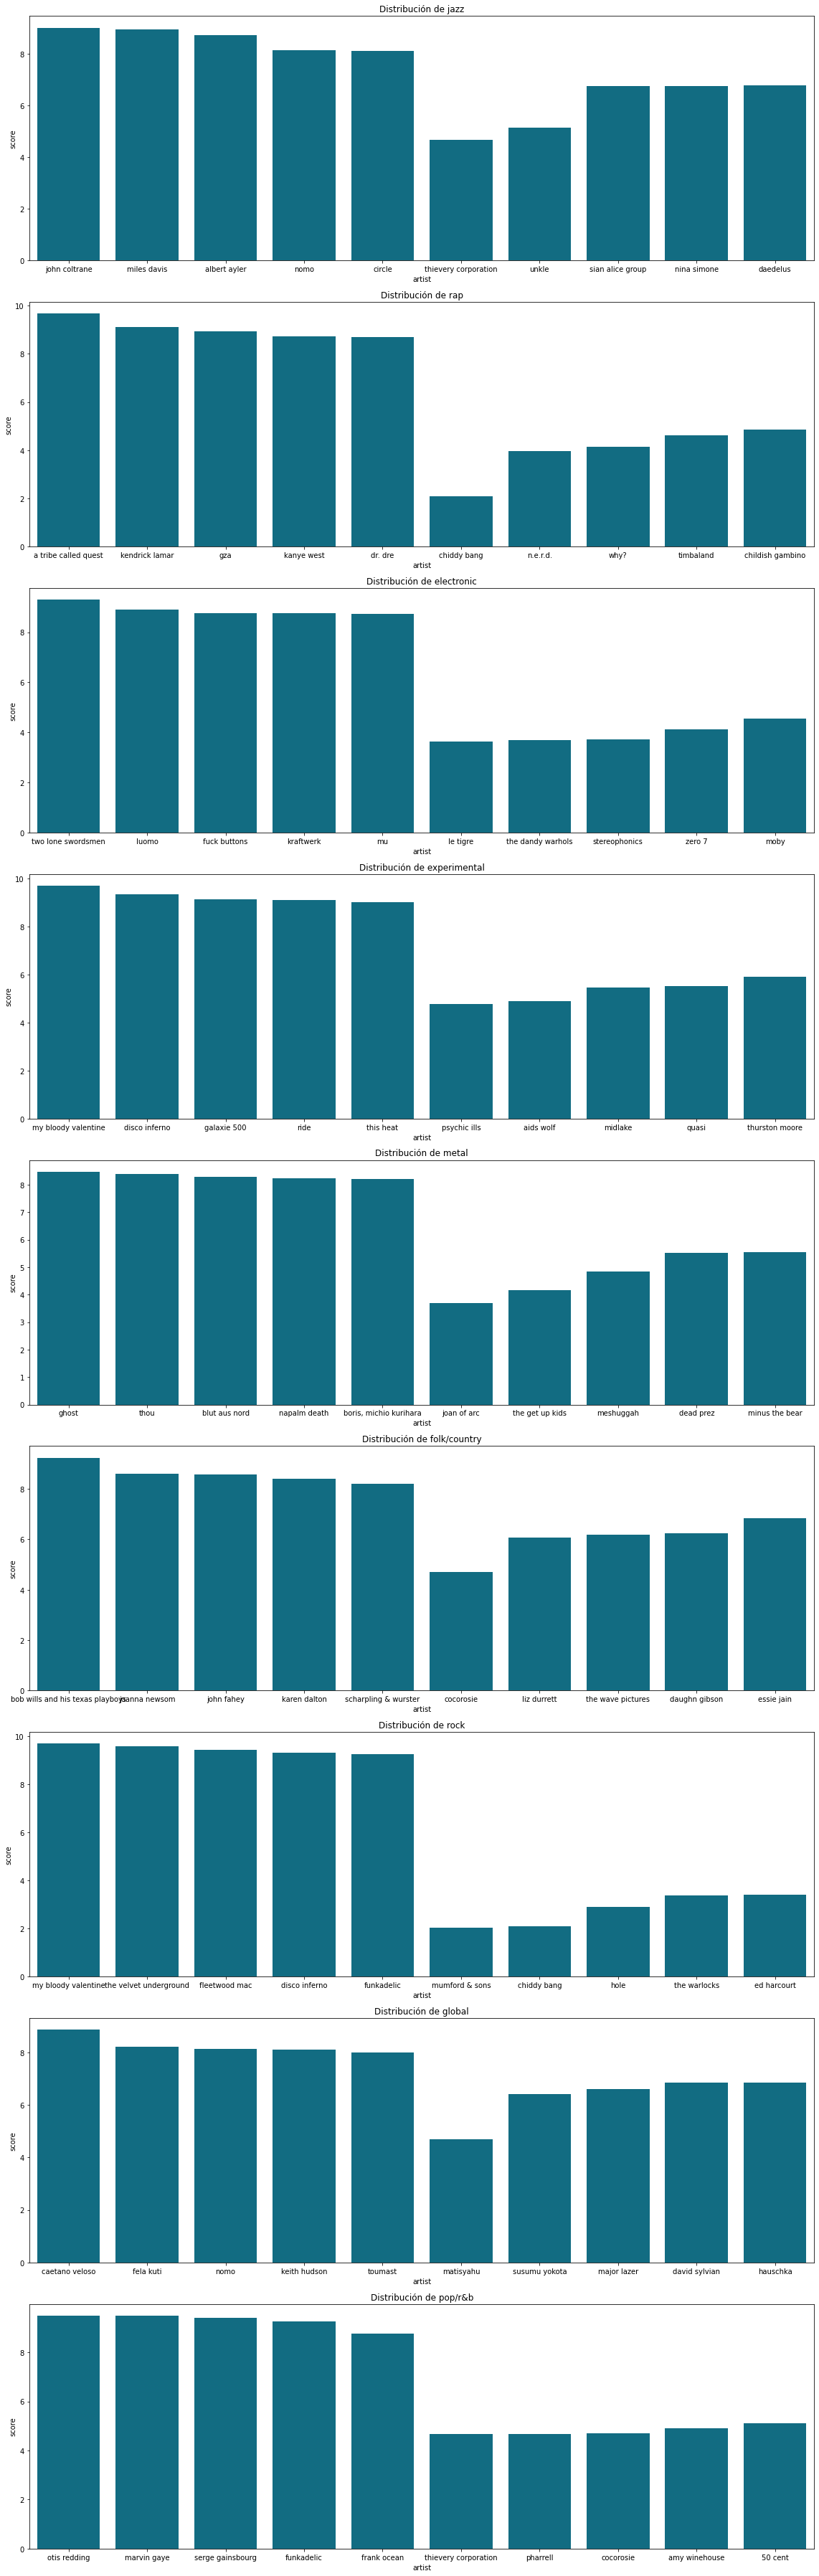

In [29]:
#Grafico de ranking de artistas por genero, en el se detallan los 5 Artistas principales y los 5 Artistas con menor scoring.
fig, ax = plt.subplots(figsize=(16,50))
for i, genre in enumerate(df_genre_artist_score_grouped_filtered_top5_bottom5_clear['genre'].unique().tolist()):
    # Plot bar distribution 
    plt.subplot(9,1,i+1);
    sns.barplot(x='artist', y='score', data=df_genre_artist_score_grouped_filtered_top5_bottom5_clear[df_genre_artist_score_grouped_filtered_top5_bottom5_clear['genre'] == genre], color='#007894')
    
    plt.title(f'Distribución de {genre}')
# Show the plot
plt.tight_layout()
plt.show()

## Conclusiones del primer análisis exploratorio referenciado a la pregunta si Pitchfork favorece a algún genero musical o desfavorece a otros?

<p> En base a los datos, podemos afirmar que los autores de las reviews tienen una tendencia a analizar los géneros de Rock, pero no se observa un favoritismo a la hora de puntuar a otros géneros. Ya que casi todos los géneros musicales tienen un scoring promedio similar. </p>
<p> Por ende es mas probable que si existen nuevos análisis de música sean de géneros de Rock o Electronic, ya que estos generos son los favoritos de los autores de las reviews. </p>



## Análisis exploratorio 2

<p>En este segundo análisis exploratorio verificaremos: ¿cuales son los temas mas recurrente que los autores de reviews plasman en sus comentarios?. ¿Estas reviews están cargados de comentarios negativos, positivos o neutrales? </p>
<p>Por lo cual se desarrollan las siguientes preguntas: </p>
<li>1.5.1 ¿Cuáles son las palabras mas recurrentes en la totalidad de reviews de los mejores y peores 5 artistas por genero ?</li>
<li>1.5.2 ¿Cuál es el top 10 de palabras en ese conjunto?</li>
<li>1.5.3 ¿Cuales es el top 15 tópicos y palabras claves de los mejores y peores 5 artistas por genero?</li>
<li>1.5.4 ¿Cuál es la evolución de sentimientos de las reviews en generos ?</li>




## 1.5.1 Cuales son las palabras mas recurrentes en la totalidad de reviews de los mejores y peores 5 artistas por genero ?

<p> Para este punto importaremos e instalaremos las librerias necesarios para analizar los datos con tecnicas de NPL y NLTK. Es importante aclarar que no se realiza sobre el total de las reviews si no sobre los mejores y peores 5 artistas calificados.</p>

In [30]:
!pip install wordcloud

In [31]:
#Determinar los artistas a anlizar los comentarios
df_top_and_buttom_artists_list =df_genre_artist_score_grouped_filtered_top5_bottom5_clear['artist'].unique().tolist()
df_top_and_buttom_artists_list

#crear dataframe con genre, artist y content
df_genre_artist_content = df[['genre','artist','content']].reset_index(drop=True)
df_genre_artist_content = df_genre_artist_content[df_genre_artist_content['artist'].isin(df_top_and_buttom_artists_list)]


In [32]:
import re

# imprimir las reviews
print(df_genre_artist_content['content'].head())

# Remove punctuation
df_genre_artist_content['content_processed'] = df_genre_artist_content['content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df_genre_artist_content['content_processed'] = df_genre_artist_content['content_processed'].map(lambda x: x.lower())

# Print the content_processed of the first rows 
df_genre_artist_content['content_processed'].head()


254    The "buzzworthy" aspects of AIDS Wolf's The Lo...
255    The "buzzworthy" aspects of AIDS Wolf's The Lo...
256    The "buzzworthy" aspects of AIDS Wolf's The Lo...
257    The "buzzworthy" aspects of AIDS Wolf's The Lo...
662    The legacy of Krautrock isn't so much in the h...
Name: content, dtype: object


254    the "buzzworthy" aspects of aids wolf's the lo...
255    the "buzzworthy" aspects of aids wolf's the lo...
256    the "buzzworthy" aspects of aids wolf's the lo...
257    the "buzzworthy" aspects of aids wolf's the lo...
662    the legacy of krautrock isn't so much in the h...
Name: content_processed, dtype: object

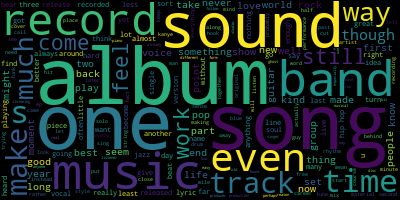

In [33]:
import wordcloud

# Join the different processed titles together.
long_string = ' '.join(df_genre_artist_content['content_processed'])

# Create a WordCloud object
wordcloud = wordcloud.WordCloud()

# Generate a word cloud

wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

<p> Dentro de la nube de palabras observamos que las palabras mas recurrentes son relacionada a álbum, música, sonido, banda entre otros. Si bien esto no nos brinda si existe alguna diferenciación entre artistas y genero. </p>



## 1.5.2 Cuales son el top 10 de palabras en ese conjunto?

<p>Continuando con el conjunto de reviews del anterior tema, necesitamos conocer si existe una palabra que destaque una diferencia entre los mejores y peores 5 artistas. Y si se habla de algún genero en particular. En esta primera instancia solo nos centraremos a analizar de forma genérica sobre todo el conjunto. </p>
<p> Para ellos utilizaremos un modelo de Machine Learning que nos permita identificar las palabras mas recurrentes en el conjunto de reviews. Que facilitara la extracción de la mismas. Esto nos permitirá generar un método automatizado para el caso de querer analizar a mayor profundidad sobre géneros u años de publicación, encontrando el top 10 en ese subconjunto. </p>


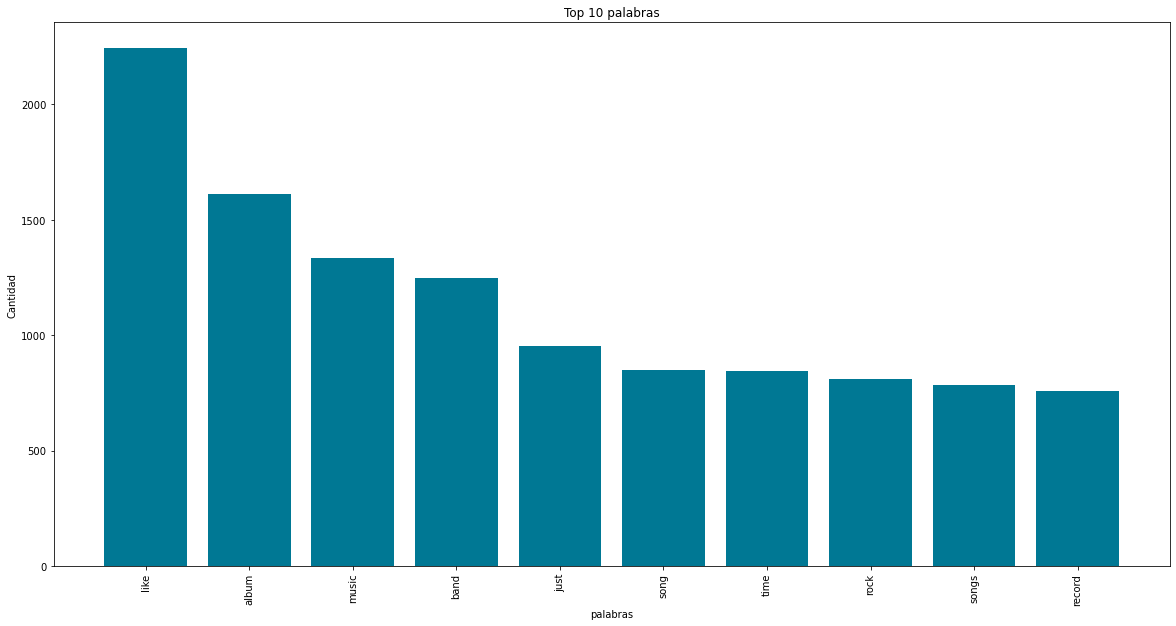

In [34]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(figsize=(20,10))
    plt.bar(x_pos, counts,align='center',color='#007894')
    
    plt.xticks(x_pos, words, rotation=90)
    
    plt.xlabel('palabras')
    plt.ylabel('Cantidad')
    plt.title('Top 10 palabras')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_genre_artist_content['content_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data,count_vectorizer)

<p>Se observa que las palabras mas recurrentes son: Like, albun, music y banda lo cual era lo esperado, lo que llama la atención es que la palabra rock tiene una alta representación en las review. Eso que solamente se analizo a 10 artistas del genero de rock, lo cual este genero ademas de ser el de mayor cantidad de reviews, se puede presuponer que los autores lo utilizan para comparar con otros generos</p>

## 1.5.3 Cuales son el top 15 tópicos y palabras claves de los mejores y peores 5 artistas por genero?

<p>Una vez descubierto las palabras claves, en el conjunto general debemos conocer el contexto en cual se usa esa palabra clave, por ende se desarrolla en un modelo de ML que nos permite conocer el contexto y tópicos que se utiliza esas palabras claves. </p>
<p> Volvemos a remarcar que este análisis, lo realizaremos sobre los mejores y peores 5 artistas de todos los géneros, pero se puede profundizar con sub análisis por géneros u años específicamente </p>
<p>A continuación se muestra los 15 tópicos mas relevantes en el conjunto de datos y las 15 palabras claves que se utilizan en ese tópico. </p>




In [35]:

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nComentario #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    
# Tweak the two parameters below (use int values below 15)
number_topics = 15
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Top de Temas de interes LDA:")
print_topics(lda, count_vectorizer, number_words)

Top de Temas de interes LDA:

Comentario #0:
like album band music just new song sound time pop songs loveless love work bloody

Comentario #1:
reed album band 50 velvet velvets underground like white davis miles set cent light just

Comentario #2:
sylvian like song lavelle songs album japan moore rock music unkle guitar record new project

Comentario #3:
like boris guitar rock kurihara album new band dandys just pink years sounds song set

Comentario #4:
album like band 50 just buckingham time rock nicks new fleetwood rumours music pop song

Comentario #5:
music band like set fahey time songs jazz davis album miles track meshuggah song sounds

Comentario #6:
like band luomo album music record rock way tracks sian 59 songs time just vocalcity

Comentario #7:
like just album gaye song going band 50 don time moby wolf songs rock man

Comentario #8:
like album music band song record kraftwerk time just sound new redding sounds track live

Comentario #9:
chiddy rap tamashek music rock dese

## 1.5.4 Cuál es la evolución de sentimientos de las reviews en los géneros ?

<p>Definido las palabras claves y los tópicos, es momento de analizar el sentimiento con el cual fue escrita la review. Por lo cual se procesara en un modelo de Analizador de intensidad de sentimiento con las librerías nltk. </p>
<p>En el siguiente cuadro se muestra si los autores de Pitchfolk han cargado de sentimientos positivos, negativos o neutrales en diferentes géneros para beneficiar o perjudicar a los artistas de diferentes géneros, o han sido imparciales. </p>

In [36]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
#analisis de sentimientos de las reviews
df_genre_artist_content['scores'] = df_genre_artist_content['content_processed'].apply(lambda review: sid.polarity_scores(review))
df_genre_artist_content['compound']  = df_genre_artist_content['scores'].apply(lambda score_dict: score_dict['compound'])
df_genre_artist_content['negativo'] = df_genre_artist_content['scores'].apply(lambda score_dict: score_dict['neg'])
df_genre_artist_content['positivo'] = df_genre_artist_content['scores'].apply(lambda score_dict: score_dict['pos'])
df_genre_artist_content['neutral'] = df_genre_artist_content['scores'].apply(lambda score_dict: score_dict['neu'])
display(df_genre_artist_content)
#agrupando por genero el total de reviews
df_genre_artist_content_grouped = df_genre_artist_content.groupby(['genre']).agg({'compound':'mean','negativo':'mean','positivo':'mean','neutral':'mean'})
display(df_genre_artist_content_grouped)




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicolascalarco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,genre,artist,content,content_processed,scores,compound,negativo,positivo,neutral
254,rock,aids wolf,"The ""buzzworthy"" aspects of AIDS Wolf's The Lo...","the ""buzzworthy"" aspects of aids wolf's the lo...","{'neg': 0.084, 'neu': 0.802, 'pos': 0.114, 'co...",0.97,0.08,0.11,0.80
255,rock,aids wolf,"The ""buzzworthy"" aspects of AIDS Wolf's The Lo...","the ""buzzworthy"" aspects of aids wolf's the lo...","{'neg': 0.084, 'neu': 0.802, 'pos': 0.114, 'co...",0.97,0.08,0.11,0.80
256,experimental,aids wolf,"The ""buzzworthy"" aspects of AIDS Wolf's The Lo...","the ""buzzworthy"" aspects of aids wolf's the lo...","{'neg': 0.084, 'neu': 0.802, 'pos': 0.114, 'co...",0.97,0.08,0.11,0.80
257,experimental,aids wolf,"The ""buzzworthy"" aspects of AIDS Wolf's The Lo...","the ""buzzworthy"" aspects of aids wolf's the lo...","{'neg': 0.084, 'neu': 0.802, 'pos': 0.114, 'co...",0.97,0.08,0.11,0.80
662,rock,circle,The legacy of Krautrock isn't so much in the h...,the legacy of krautrock isn't so much in the h...,"{'neg': 0.084, 'neu': 0.8, 'pos': 0.117, 'comp...",0.98,0.08,0.12,0.80
...,...,...,...,...,...,...,...,...,...
17398,jazz,circle,Pianist Chick Corea and saxophonist Anthony Br...,pianist chick corea and saxophonist anthony br...,"{'neg': 0.031, 'neu': 0.845, 'pos': 0.124, 'co...",1.00,0.03,0.12,0.84
17584,metal,meshuggah,Meshuggah’s first album in four years begins w...,meshuggah’s first album in four years begins w...,"{'neg': 0.073, 'neu': 0.868, 'pos': 0.059, 'co...",-0.93,0.07,0.06,0.87
17650,pop/r&b,otis redding,“We’re hoping that this be one of the greatest...,“we’re hoping that this be one of the greatest...,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co...",1.00,0.04,0.12,0.84
17680,rap,a tribe called quest,"Since their 1990 debut, People’s Instinctive T...",since their 1990 debut people’s instinctive tr...,"{'neg': 0.049, 'neu': 0.872, 'pos': 0.079, 'co...",0.99,0.05,0.08,0.87


,compound,negativo,positivo,neutral
genre,,,,
electronic,0.57,0.07,0.12,0.81
experimental,0.85,0.06,0.12,0.82
folk/country,0.68,0.06,0.12,0.81
global,0.82,0.06,0.13,0.81
jazz,0.88,0.06,0.12,0.83
metal,0.37,0.08,0.11,0.81
pop/r&b,0.76,0.08,0.13,0.79
rap,0.50,0.10,0.12,0.78
rock,0.73,0.07,0.12,0.81


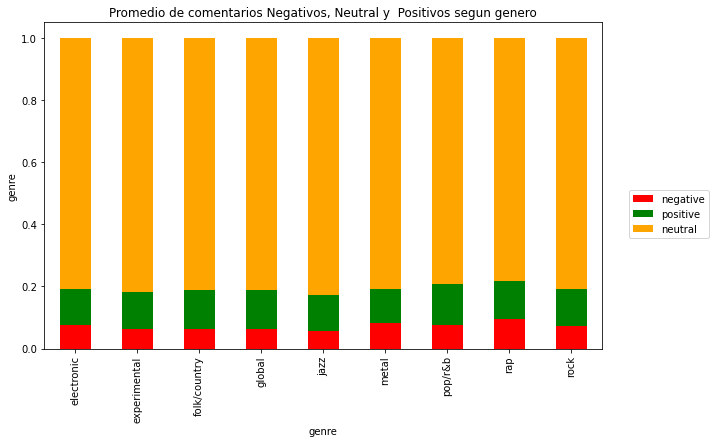

In [37]:
TITLE = "Promedio de comentarios Negativos, Neutral y  Positivos segun genero"
COLORS = ["red","green", "orange"]
# Drop the columns that aren't useful for the plot
plot_genre = df_genre_artist_content_grouped.drop(['compound'], 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_genre.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_genre.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("genre");

<p>Según lo que se observa el genero Rap fue levemente el que mas sentimientos negativos obtuvo en la reviews seguido de los géneros Metal y Pop/r&b, situación similar con las reviews positivas en los géneros Pop y Global. </p>
<p> Por lo cual suponemos que no existe una carga desbalanciada de intencionalidad en la elaboración de reviews por parte de los autores, dentro del conjunto seleccionado de los mejores y peores 5 artistas de todos los géneros. </p>


## Conclusión análisis exploratorio 2

<p>¿cuales son los temas mas recurrente que los autores de reviews plasman en sus comentarios?</p>
<li>Las palabras mas recurrentes son referidos a elementos y sentimientos musicales, observándose como palabra distintiva la palabra rock la cual es fuertemente utilizada, en mas de un genero (mas de 700 menciones), por lo cual se puede considerar como una palabra clave para el análisis de reviews. </li> 
<li>Se puede realizar una investigación en cada genero para descubrir palabras claves a lo largo de cada año, y ver si existe una evolución en el tiempo.</li>
<li> El genero que se debería realizar el análisis seria “Rock”, por observarse como genero y palabra con mas preferencias en las reviews</p>

<p> Con respecto a si estas reviews están cargados de comentarios negativos, positivos o neutrales observamos que en esta muestra no existe una variación significativa entre los géneros y que la mayoría mantiene las medias generales del conjunto. </p>


## 1.6 Analisis exploratorio de los rolles de author_type
<p> Se desarrolla inicialmente: </p>
<li>1.6.1 ¿Cuál es la distribución general de los rolles de author_type?</li>
<li>1.6.2 ¿Cuál es la distribución de los rolles de author_type por año?</li>
<li>1.6.3 ¿cuál es el sentimiento promedio que se obtiene de las reviews de Pitchfork?</li>
<li>1.6.4 ¿Cuál es la distribución de los rolles de author_type por sentimiento a lo largo de los años?</li>


## 1.6.1 Cuál es la distribución general de los rolles de author_type?

<p>Para analizar este caso, se tomara el total de las reviews segmentada por tipo de autor, se pretende conseguir al grupo mas relevante para el análisis. </p>

In [38]:
#Armado de tabla de variables, frecuencia y porcentaje de cada variable de df['author_type']:
# Count the number of review in each 'author_type'.
author_type_counts = df['author_type'].value_counts()
df_frec_author_type = pd.DataFrame(author_type_counts)
#Asignar el nombre de frecuencia a la columna
df_frec_author_type.columns = ['frecuencia Absoluta']
#Determinar la frecuencia relativa en porcentaje
df_frec_author_type['frecuencia Relativa'] = df_frec_author_type['frecuencia Absoluta'] / df_frec_author_type['frecuencia Absoluta'].sum()
#Determinar el porcentaje de cada variable
df_frec_author_type['frecuencia Relativa'] = df_frec_author_type['frecuencia Relativa'] *100
#Ordenar la tabla por frecuencia relativa
df_frec_author_type.sort_values(by=['frecuencia Relativa'], ascending=False, inplace=True)
#Determinar el porcentaje acumulado de la frecuencia relativa
df_frec_author_type['frecuencia Relativa Acumulada'] = df_frec_author_type['frecuencia Relativa'].cumsum()
#Asignar el nombre de porcentaje a la columna
df_frec_author_type.columns = ['frecuencia Absoluta', 'frecuencia Relativa','frecuencia Relativa Acumulada']
#Mostrar la tabla
pd.options.display.float_format = '{:.2f}%'.format
display(df_frec_author_type)
pd.options.display.float_format = '{:.2f}'.format

,frecuencia Absoluta,frecuencia Relativa,frecuencia Relativa Acumulada
contributor,15177,85.23%,85.23%
executive editor,668,3.75%,88.98%
senior editor,631,3.54%,92.52%
senior staff writer,604,3.39%,95.91%
contributing editor,233,1.31%,97.22%
associate staff writer,116,0.65%,97.87%
deputy news editor,104,0.58%,98.46%
editor-in-chief,76,0.43%,98.88%
tracks coordinator,53,0.30%,99.18%
associate editor,51,0.29%,99.47%


<p> Con el 85 % de elaboración de reviews se selecciona los autores con el perfil de contribuidor para continuar con la elaboración del análisis. </p>
<p> Se expondra en tabla la cantidad de reviews y cuantas de esas son de los best_new_music de ese año


,pub_year,author_type,cantidad de reviews,cantidad de reviews best_new_music
0,1999,contributor,52,0
2,2000,contributor,94,0
4,2001,contributor,171,0
7,2002,contributor,483,0
10,2003,contributor,800,50
13,2004,contributor,886,43
18,2005,contributor,837,45
25,2006,contributor,892,31
32,2007,contributor,971,37
39,2008,contributor,964,39


Text(0.5, 1.0, 'Cantidad de reviews por año y tipo de autor contributor')

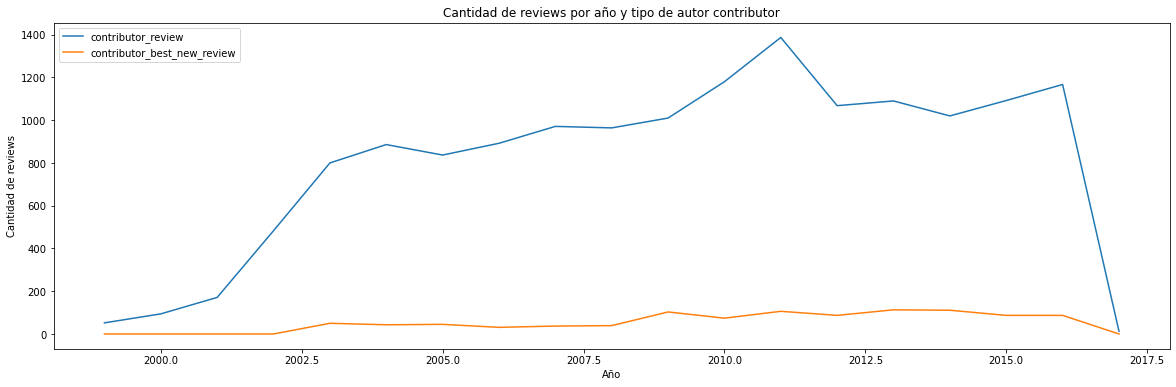

In [39]:
#Armado de tabla de cantidades de reviews por author_type y pub_year
# Count the number of review in each 'author_type'.
author_type_counts_pub_year = df[['author_type','pub_year','best_new_music']]
author_type_counts_pub_year = author_type_counts_pub_year.groupby(['pub_year','author_type']).agg({'pub_year':'count','best_new_music':'sum'})
author_type_counts_pub_year.columns = ['cantidad de reviews','cantidad de reviews best_new_music']
author_type_counts_pub_year.reset_index(inplace=True)
author_type_counts_pub_year.sort_values(by=['pub_year'], ascending=True, inplace=True)
author_type_counts_pub_year_contributor = author_type_counts_pub_year[author_type_counts_pub_year['author_type']=='contributor']
display(author_type_counts_pub_year_contributor)
#grafico de linea de author_type_counts_pub_year_contributor y pub_year
plt.figure(figsize=(20,6))
ax5 = plt.plot(author_type_counts_pub_year_contributor['pub_year'],author_type_counts_pub_year_contributor['cantidad de reviews'],label='contributor_review')
ax6 = plt.plot(author_type_counts_pub_year_contributor['pub_year'],author_type_counts_pub_year_contributor['cantidad de reviews best_new_music'],label='contributor_best_new_review')
plt.legend(loc='upper left')
plt.xlabel('Año')
plt.ylabel('Cantidad de reviews')
plt.title('Cantidad de reviews por año y tipo de autor contributor')

### Distrubición de las reviews por genero y año

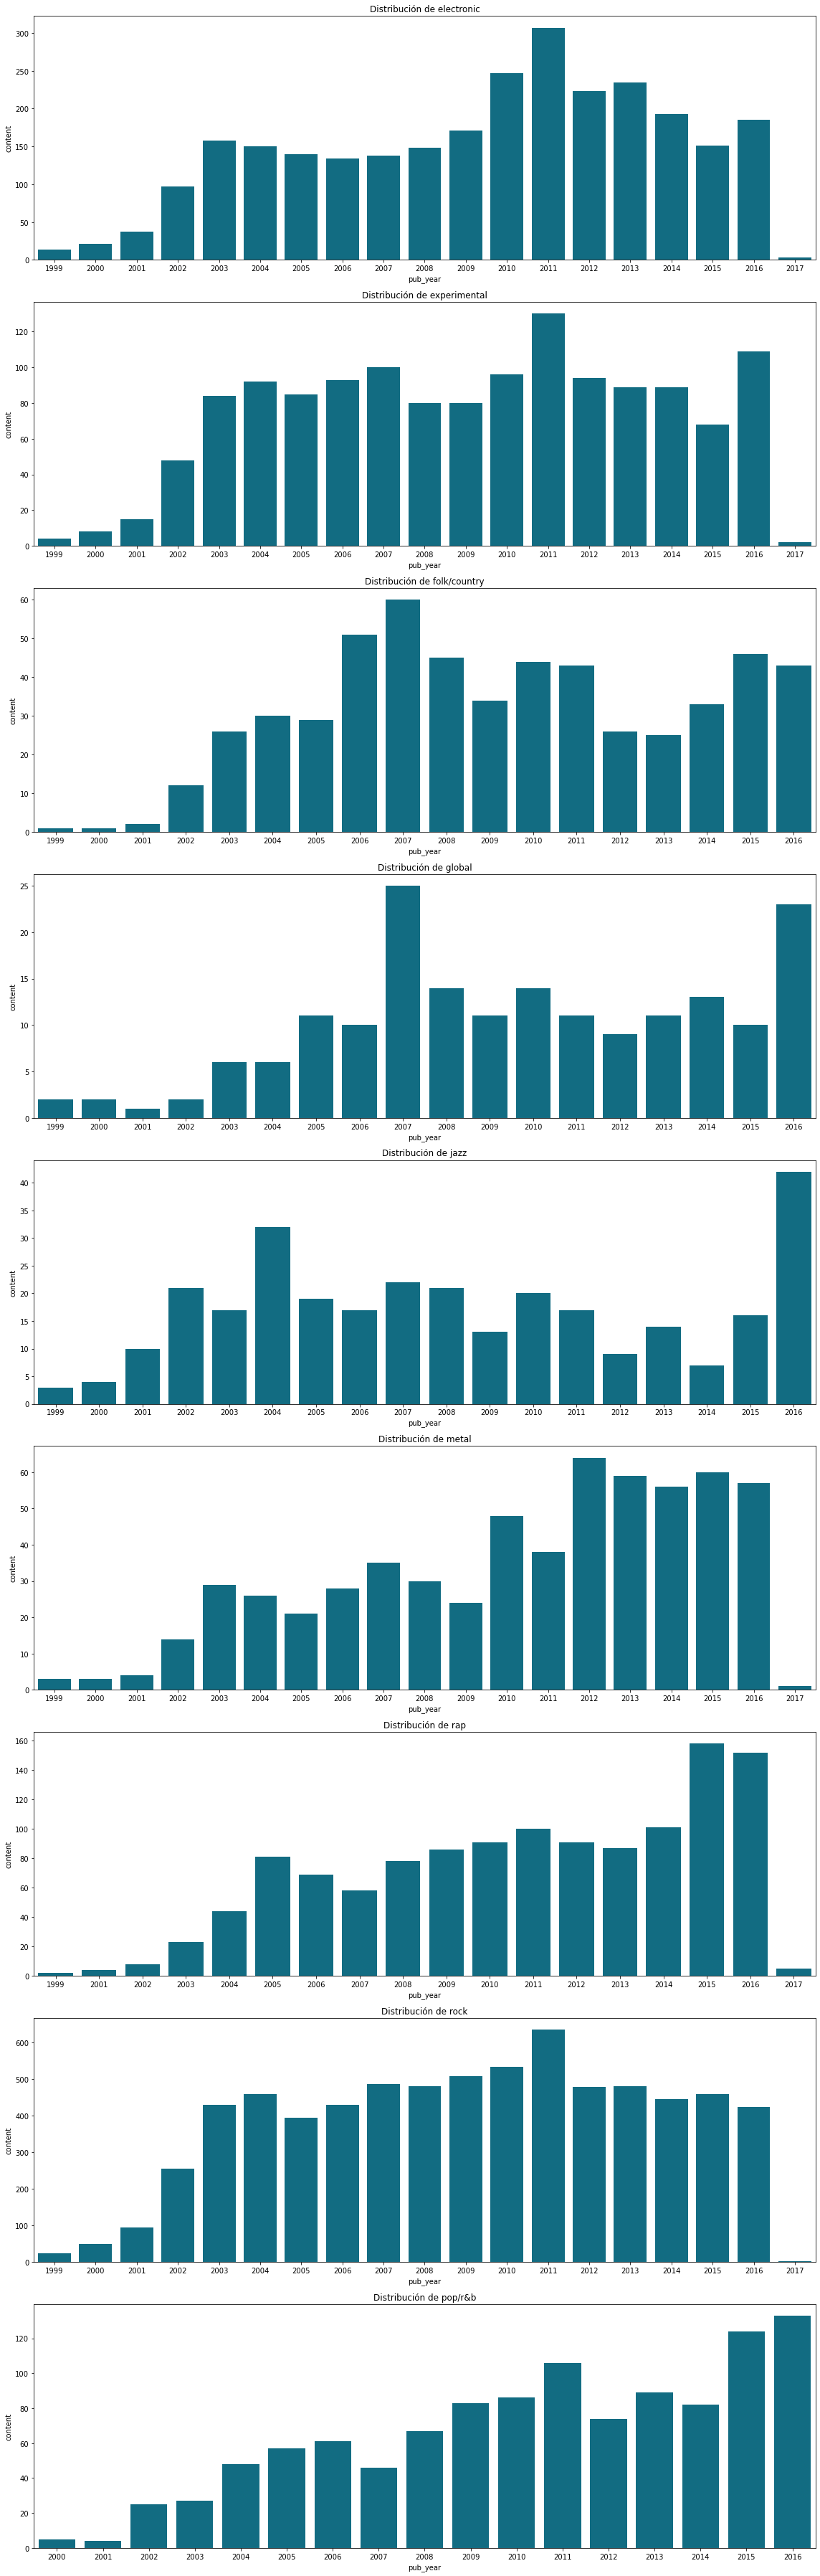

In [40]:
#Armado de tabla de cantidades de reviews por author type y genero
author_type_counts_genre = df[['author_type','genre','pub_year','content','best_new_music']]
author_type_counts_genre = author_type_counts_genre.groupby(['author_type','pub_year','genre']).agg({'content':'count','best_new_music':'sum'})
author_type_counts_genre.reset_index(inplace=True)
author_type_counts_genre =author_type_counts_genre[author_type_counts_genre['author_type']=='contributor']
#grafico de lineas apiladas de años y generos
#Grafico de ranking de artistas por genero, en el se detallan los 5 Artistas principales y los 5 Artistas con menor scoring.
fig, ax = plt.subplots(figsize=(16,50))
for i, genre in enumerate(author_type_counts_genre['genre'].unique().tolist()):
    # Plot bar distribution 
    plt.subplot(9,1,i+1);
    sns.barplot(x='pub_year', y='content', data=author_type_counts_genre[author_type_counts_genre['genre'] == genre], color='#007894')
    
    plt.title(f'Distribución de {genre}')
# Show the plot
plt.tight_layout()
plt.show()

<p> Se observa que la distribución de review generada por los contribuidores se  mantiene en casi todos los géneros con una tendencia similar, variando únicamente en los géneros "Rock" y "Electronica" que por la gran cantidad de reviews se mantiene constantemente en casi todos los años por encima de la reviews media anual.</p>

### Analisis de tipo de sentimiento publicado por Pitchfork y año
Para ello trabajaremos con el total de las reviews con la función trabajada anteriormente de NLTK para obtener el sentimiento de la review. Enfocando en dos partes, una parte seria las reviews por sentimiento sin desagregar por géneros y la segunda parte desagregada, esto nos permitirá conocer la media general y la obtenida por cada genero para identificar si existe algún patrón de sentimiento en el conjunto de datos por genero y año.



In [41]:
#Armado de la tabla a trabajar
author_type_counts_pub_year_content = df[['author_type','genre','pub_year','best_new_music','content']]
author_type_counts_pub_year_content = author_type_counts_pub_year_content[author_type_counts_pub_year_content['author_type'] == 'contributor']
author_type_counts_pub_year_content

#analisis de sentimientos de las reviews
author_type_counts_pub_year_content['scores'] = author_type_counts_pub_year_content['content'].apply(lambda review: sid.polarity_scores(review))
author_type_counts_pub_year_content['compound']  = author_type_counts_pub_year_content['scores'].apply(lambda score_dict: score_dict['compound'])
author_type_counts_pub_year_content['negativo'] = author_type_counts_pub_year_content['scores'].apply(lambda score_dict: score_dict['neg'])
author_type_counts_pub_year_content['neutral'] = author_type_counts_pub_year_content['scores'].apply(lambda score_dict: score_dict['neu'])
author_type_counts_pub_year_content['positivo'] = author_type_counts_pub_year_content['scores'].apply(lambda score_dict: score_dict['pos'])
display(author_type_counts_pub_year_content)
#agrupando por genero el total de reviews
author_type_counts_pub_year_content_gruped_clear = author_type_counts_pub_year_content.groupby(['genre','pub_year']).agg({'compound':'mean','negativo':'mean','neutral':'mean','positivo':'mean'})
display(author_type_counts_pub_year_content_gruped_clear)

,author_type,genre,pub_year,best_new_music,content,scores,compound,negativo,neutral,positivo
reviewid,,,,,,,,,,
6,contributor,electronic,2003,0,Can there be any purpose behind a master's deg...,"{'neg': 0.088, 'neu': 0.749, 'pos': 0.163, 'co...",1.00,0.09,0.75,0.16
11,contributor,rock,2002,0,"If you caught this little blip in the mid-90s,...","{'neg': 0.05, 'neu': 0.74, 'pos': 0.21, 'compo...",1.00,0.05,0.74,0.21
15,contributor,rock,2003,0,Brad Nessler: Welcome to our wrap-up of Game F...,"{'neg': 0.07, 'neu': 0.798, 'pos': 0.132, 'com...",0.99,0.07,0.80,0.13
15,contributor,rap,2003,0,Brad Nessler: Welcome to our wrap-up of Game F...,"{'neg': 0.07, 'neu': 0.798, 'pos': 0.132, 'com...",0.99,0.07,0.80,0.13
16,contributor,rock,2003,0,Aceyalone's transcendent smoothness is such th...,"{'neg': 0.062, 'neu': 0.825, 'pos': 0.113, 'co...",0.98,0.06,0.82,0.11
...,...,...,...,...,...,...,...,...,...,...
22718,contributor,rock,2016,0,Nine Inch Nails mastermind Trent Reznor has sp...,"{'neg': 0.086, 'neu': 0.779, 'pos': 0.136, 'co...",0.99,0.09,0.78,0.14
22720,contributor,rap,2017,0,"In January 2016, rapper/actor Yasiin Bey annou...","{'neg': 0.105, 'neu': 0.797, 'pos': 0.098, 'co...",-0.67,0.10,0.80,0.10
22720,contributor,rap,2017,0,"In January 2016, rapper/actor Yasiin Bey annou...","{'neg': 0.105, 'neu': 0.797, 'pos': 0.098, 'co...",-0.67,0.10,0.80,0.10


compound  negativo  neutral  positivo
genre      pub_year                                       
electronic 1999          0.57      0.08     0.81      0.11
           2000          0.75      0.07     0.81      0.12
           2001          0.76      0.07     0.81      0.12
           2002          0.85      0.07     0.81      0.12
           2003          0.77      0.07     0.81      0.12
...                       ...       ...      ...       ...
rock       2013          0.78      0.07     0.81      0.12
           2014          0.78      0.07     0.82      0.12
           2015          0.72      0.07     0.81      0.12
           2016          0.68      0.07     0.81      0.12
           2017          0.96      0.05     0.86      0.09

[165 rows x 4 columns]

### Distribución General por año de publicación

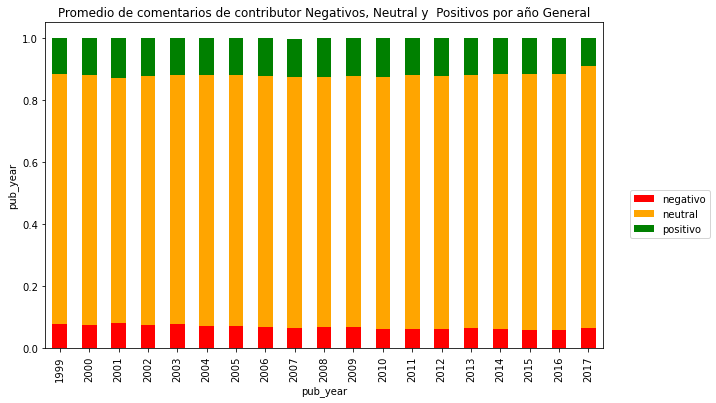

In [43]:
TITLE = "Promedio de comentarios de contributor Negativos, Neutral y  Positivos por año General"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
author_type_counts_pub_year_content_gruped_clear = author_type_counts_pub_year_content_gruped_clear.reset_index()
plot_year = author_type_counts_pub_year_content_gruped_clear.drop(['compound','genre'], 1).groupby('pub_year').mean()
# Change the column names to 'negative', 'positive', and 'neutral'
#plot_year.columns = ['negative', 'neutral', 'positivo']
# Plot a stacked bar chart
#display(plot_year)
plot_year.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("pub_year");

In [44]:

author_type_counts_pub_year_content_gruped_clear = author_type_counts_pub_year_content.groupby(['genre','pub_year']).agg({'compound':'mean','negativo':'mean','neutral':'mean','positivo':'mean'})
author_type_counts_pub_year_content_gruped_clear= author_type_counts_pub_year_content_gruped_clear.reset_index()
display(author_type_counts_pub_year_content_gruped_clear)


,genre,pub_year,compound,negativo,neutral,positivo
0,electronic,1999,0.57,0.08,0.81,0.11
1,electronic,2000,0.75,0.07,0.81,0.12
2,electronic,2001,0.76,0.07,0.81,0.12
3,electronic,2002,0.85,0.07,0.81,0.12
4,electronic,2003,0.77,0.07,0.81,0.12
...,...,...,...,...,...,...
160,rock,2013,0.78,0.07,0.81,0.12
161,rock,2014,0.78,0.07,0.82,0.12
162,rock,2015,0.72,0.07,0.81,0.12
163,rock,2016,0.68,0.07,0.81,0.12


### Distribución de reviews por sentimiento, año y genero

Se observa en el cuadro inferior los inputs mas relevantes en cada genero:
Electronic:
<li> En el año 2017 incremento de las reviews con sentimientos negativos disminuyendo en proporción similar a los sentimientos positivos.</li>
Folk/country:
<li> En el año 2000 incremento de las reviews con sentimientos positivos incremento considerablemente imposibilitando mantenerlo en los años subsiguientes</li>
Metal:
<li> En el año 2017 se disminuyo considerablemente las reviews con sentimientos positivos, pero no se traslado la cantidad de reviews con sentimientos negativos, por lo cual se mantiene en el año 2017</li>
Rock:
<li> En el año 2017 se disminuyo considerablemente las reviews con sentimientos positivos y negativos , pero se traslado la cantidad de reviews con sentimientos neutral, por lo cual no hubo una variación considerable en el criterio general del genero</li>

Durante los 2000 hasta 2017 no se visualiza grandes variaciones en la forma de escribir de los autores, ni se vieron influenciados por algún genero en especial. por lo cual observamos que los autores fueron bastante consistentes en su escritura, y que no existe una variación significativa en la cantidad de reviews por genero y año.



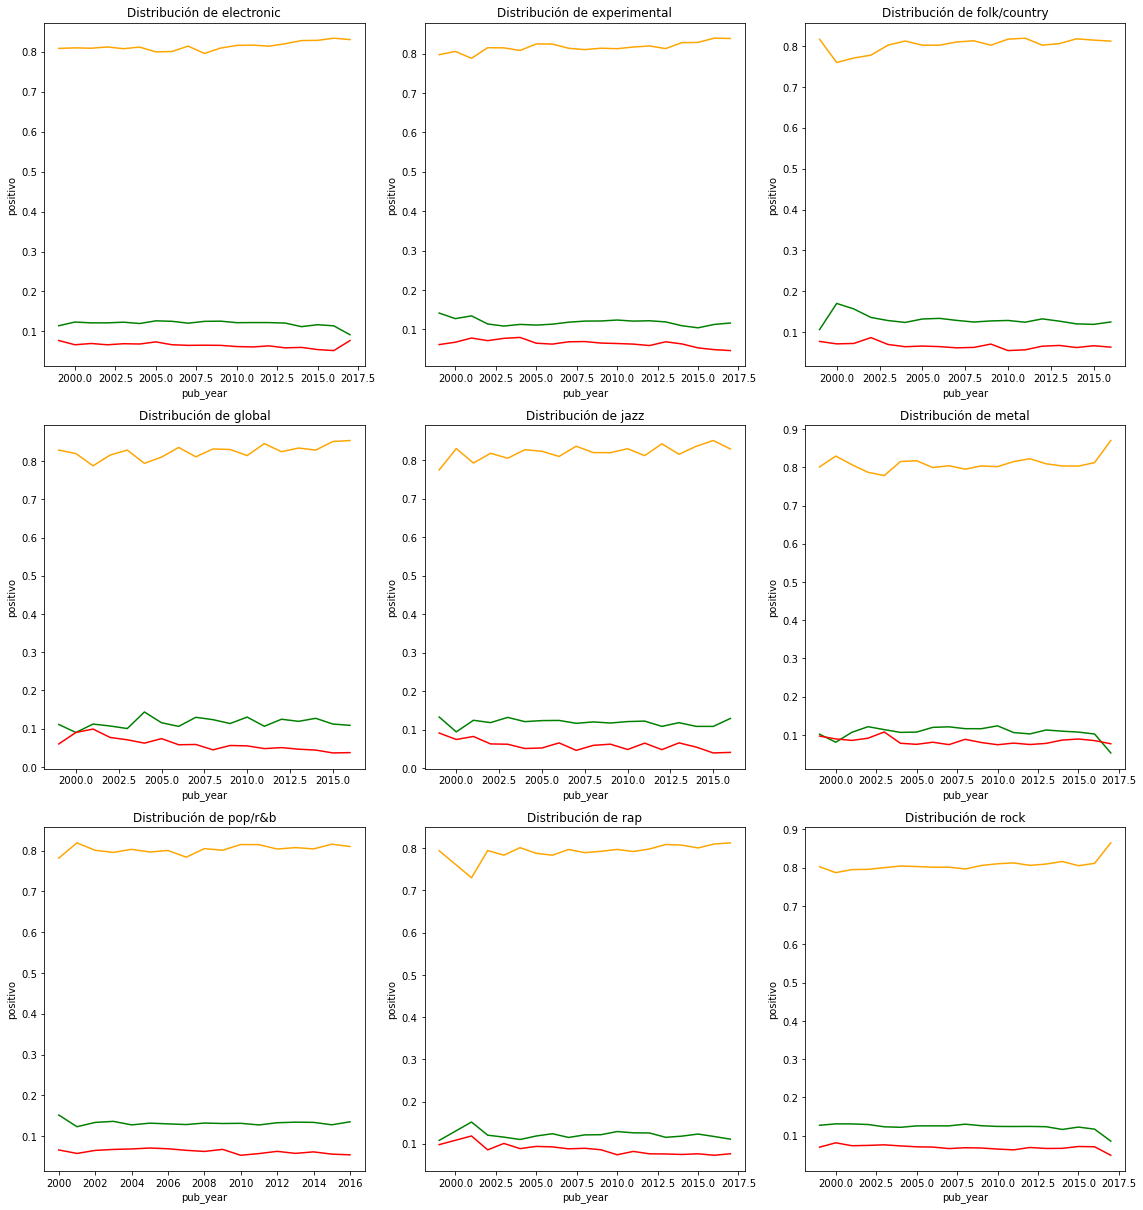

In [45]:

fig, ax = plt.subplots(figsize=(16,50))
for i, genre in enumerate(author_type_counts_pub_year_content_gruped_clear['genre'].unique().tolist()):
    # Plot bar distribution 
    plt.subplot(9,3,i+1);
    TITLE = "Promedio de comentarios de contributor Negativos, Neutral y  Positivos por año"
    COLORS = ["red","orange", "green"]
    data = author_type_counts_pub_year_content_gruped_clear[author_type_counts_pub_year_content_gruped_clear['genre'] == genre].drop(['genre','compound'], 1)
    #display(data)
    sns.lineplot(x='pub_year', y='positivo', data=data, color='green')
    sns.lineplot(x='pub_year', y='neutral', data=data, color='orange')
    sns.lineplot(x='pub_year', y='negativo', data=data, color='red')
    #data.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
    plt.title(f'Distribución de {genre}')
# Show the plot
plt.tight_layout()
plt.show()

## Analisis de sentimientos general de las reviews por año y best_new_music


In [46]:
author_type_counts_pub_year_content_gruped_best_new_music = author_type_counts_pub_year_content[author_type_counts_pub_year_content['best_new_music']==1]
author_type_counts_pub_year_content_gruped_best_new_music_clear = author_type_counts_pub_year_content_gruped_best_new_music.groupby(['pub_year']).agg({'compound':'mean','negativo':'mean','neutral':'mean','positivo':'mean'})
display(author_type_counts_pub_year_content_gruped_best_new_music_clear)

,compound,negativo,neutral,positivo
pub_year,,,,
2003,0.59,0.09,0.78,0.13
2004,0.81,0.07,0.78,0.14
2005,0.91,0.08,0.79,0.13
2006,0.89,0.06,0.82,0.12
2007,0.68,0.07,0.80,0.13
2008,0.87,0.07,0.80,0.13
2009,0.82,0.07,0.81,0.12
2010,0.75,0.07,0.80,0.13
2011,0.73,0.07,0.80,0.13


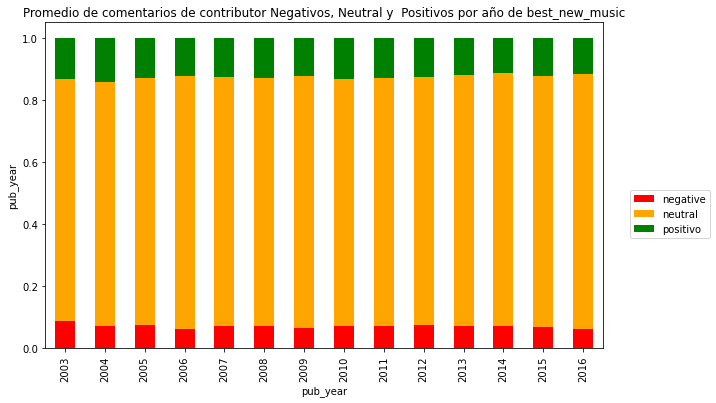

In [47]:
TITLE = "Promedio de comentarios de contributor Negativos, Neutral y  Positivos por año de best_new_music"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_year_new = author_type_counts_pub_year_content_gruped_best_new_music_clear.drop(['compound'], 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_year_new.columns = ['negative', 'neutral', 'positivo']
# Plot a stacked bar chart
plot_year_new.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("pub_year");

### 1.6 Conclusiones sobre los autores contribuidores de las reviews

<p> No existe diferencias sustancias sobre los best_new_music y el general de los title que los autores con el perfil contribuidor, en lo que respecta a de sentimientos plasmados en sus reviews. Esta brinda a pensar que muchos de las reviews son respuestas genéricas y no se trata de una respuesta personalizada. Igualmente este primer pensamiento se basa en una generalidad, que puede ser desmentida si se analiza los éxitos de cada genero. </p>




# 2 Conclusiones personales sobre el análisis de los datos de Pichfork.com

Como analista, puedo detallar que la empresa tiene autores de reviews con preferencias sobre la música en el genero "Rock" y "Electronica", si bien, faltan los nuevos géneros que en la actualidad están tomando una relevancia considerable, no se observa con la llegada de otras plataformas de música como por ejemplo Youtube y Spotify influencia sobre los géneros y el scoring. Ni tampoco si el marketing afecto de forma positiva o negativa sobre los genero "Global" y "Pop" los cuales son mas influyentes en estas plataformas como YT y Spotify.

De igual manera, como es una empresa que se dedica al mundo de la música, puede ser que los posteos de las reviews estén alineados con las preferencias de los lectores que consumen la plataforma. Pero al no conocer el modelo de negocios de Pitchfork, no se puede afirmar ni descartar esta posibilidad(que las reviews estén patrocinadas por las grandes disqueras musicales).

Adicionalmente se destaca a los autores de reviews que no se observo preferencias, en el énfasis de sentimientos de los contenidos de las reviews, ni preferencias en los géneros evitando favorecer de sobre manera a algún genero u artista manteniendo la imparcialidad de sus opiniones.

Como apreciación persona si tuviera que incorporar un nuevo artista en el mundo de la música le recomendaría, si el genero con el cual se identifica es de rock, electrónica u experimental, que realice una review en este sitio ya que podría incidir positivamente en la dicha carrera música por el publico el cual consume esta plataforma.